## ALICE Corner Finding Tests

__Question__: Can we improve the coner findin code and can we use cv2.approxPoly to assume the label quadtrilateral with only the CNN mask?

__TL;DR__: Seems so.

#### Imports

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import skimage.io as io
import cv2
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from source_functions.main import *
from source_functions.label_merging import align_merged_label
from source_functions.alignment_helper_functions import combine_masks,find_label_contour_boundaries

#### Test Sample

In [61]:
img_pth = '../../ALICE_Data/resized/train/013612439_additional_1.JPG'
msk_pth = 'CNN_Results/sample_tests/samp_masks/013612439_additional_1_0.npy'

#### Current Method
Current method of approximating corners based on CNN mask:

In [62]:
# Params
#########
ydist=False
combine_extra_masks = True
reconfig_method=0
paths=True



mask, img_orig, corners_x, corners_y = find_corners(
    msk_pth,
    img_pth,
    ydist=ydist,
    combine_extra_masks=combine_extra_masks,
    paths=paths,
)


# Define short sides and long sides:
short_inds, long_inds, _, dists_dict = define_label_sides(corners_x, corners_y)

# Update corners of parallelogram:
corners_x_updated, corners_y_updated = reconfigure_corner(
    short_inds, long_inds, dists_dict, corners_x, corners_y, method=reconfig_method
)

### TL;DR - New Method
New method of approximating corners based on CNN mask. This method still uses the find_direction function like the previous method. However, this time, this is followed by a different version of the find_label_corners function.

In [46]:
def find_corners_v2(mask,angleMax=30,angleTotal=11,epsilon=15,return_values=0):

    # 1) Find two perpendicular lines of label:
    new_lines, line, swapped, contours = find_direction(mask)

    # 2) Find the corner where the two lines join:
    A1 = [new_lines[0][0][0],new_lines[0][1][0]]
    B1 = [new_lines[0][0][-1],new_lines[0][1][-1]]
    A2 = [new_lines[1][0][0],new_lines[1][1][0]]
    B2 = [new_lines[1][0][-1],new_lines[1][1][-1]]
    # We do this by computing the distances between the four points. 
    d1 = dist_two_points(A1[0], A1[1], A2[0], A2[1], ydist=False)
    d2 = dist_two_points(B1[0], B1[1], A2[0], A2[1], ydist=False)
    d3 = dist_two_points(A1[0], A1[1], B2[0], B2[1], ydist=False)
    d4 = dist_two_points(B1[0], B1[1], B2[0], B2[1], ydist=False)

    v = np.argmin([d1,d2,d3,d4])

    corners_ = [[A1,A2,B1,B2],[B1,A2,A1,B2],[A1,B2,B1,A2],[B1,B2,A1,A2]][v]
    # 3) Create new corner by computing the average between the close points:
    avg_corner = (np.array(corners_[1])+np.array(corners_[0]))/2
    x1,y1 = avg_corner

    #  4) Find approximate fourth side by translating one side:
    xe,ye = avg_corner-np.array(corners_[2])
    x = [corners_[2][0],corners_[3][0]-xe]
    y = [corners_[2][1],corners_[3][1]-ye]

    # 5) Adjust the new side by rotating it until it is better aligned with label contour:
    # Specify origin.
    cx = corners_[2][0]
    cy = corners_[2][1]

    vals = np.sort(np.unique(np.round(contours[0])))


    # Create rotated lines.
    angles = np.linspace(0, angleMax, angleTotal)[1:]
    coords1 = line_rotation(x, y, cx, cy, vals, angles)
    angles = np.linspace(-1 * angleMax, 0, angleTotal)[:-1]
    coords2 = line_rotation(x, y, cx, cy, vals, angles)

    x_round, y_round = removeReps(np.round(contours[0]), np.round(contours[1]))

    # Count total aligned points.
    tot1 = [
        total_alignments(coord, x_round, y_round, epsilon=epsilon)[0]
        for coord in coords1
    ]
    tot2 = [
        total_alignments(coord, x_round, y_round, epsilon=epsilon)[0]
        for coord in coords2
    ]

    # 6) Select rotated line that is most aligned with original contour:
    if max(tot1) > max(tot2):
        m = np.argmax(tot1)
        new_line_ = coords1[m]
    else:
        m = np.argmax(tot2)
        new_line_ = coords2[m]

    # 7) Update list of four corners:
    
    d_1 = dist_two_points(new_line_[0][-1], new_line_[1][-1], corners_[2][0], corners_[2][1], ydist=False)
    d_2 = dist_two_points(new_line_[0][0], new_line_[1][0], corners_[2][0], corners_[2][1], ydist=False)
    
    if d_1 > d_2:
        corners_x2 = [corners_[3][0],new_line_[0][-1],new_line_[0][0],x1]
        corners_y2 = [corners_[3][1],new_line_[1][-1],new_line_[1][0],y1]
    else:    
        corners_x2 = [corners_[3][0],new_line_[0][0],new_line_[0][-1],x1]
        corners_y2 = [corners_[3][1],new_line_[1][0],new_line_[1][-1],y1]

    
    
    if return_values == 0:
        return corners_x2,corners_y2,contours
    else:
        return corners_x2,corners_y2,contours,new_lines,[x,y]

In [63]:
corners_x2, corners_y2,contours = find_corners_v2(mask)

# Define short sides and long sides:
short_inds, long_inds, _, dists_dict = define_label_sides(corners_x2, corners_y2)

# Update corners of parallelogram:
corners_x_updated2, corners_y_updated2 = reconfigure_corner(
    short_inds, long_inds, dists_dict, corners_x2, corners_y2, method=reconfig_method
)

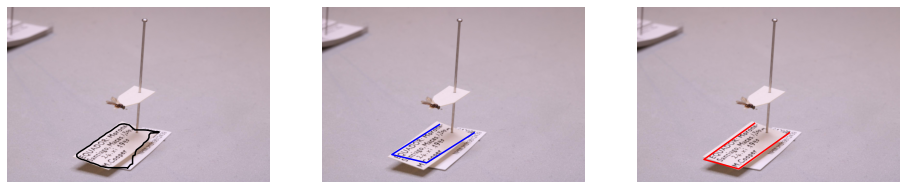

In [64]:
fig,ax = plt.subplots(1,3,figsize=(16,5))
for i in range(0,3):
    ax[i].imshow(img_orig)
    ax[i].axis('off')
ax[0].plot(contours[0],contours[1],'-k') #original contour from mask
ax[1].plot(corners_x_updated,corners_y_updated,'-b') # original corner finding function
ax[2].plot(corners_x_updated2,corners_y_updated2,'-r') # new corner finding method

## SCRAP BOOK

### Workings of New Corner Finding Method

__IDEA 1__: When finding two perpendicular sides in find_direction, we rotate lines and count the intersections between the rotated line and the original mask contour. We now test whether a similar method can be used in finding the fourth corner.

In [12]:
new_lines, line, swapped, contours = find_direction(mask)

In [30]:
A1 = [new_lines[0][0][0],new_lines[0][1][0]]
B1 = [new_lines[0][0][-1],new_lines[0][1][-1]]

A2 = [new_lines[1][0][0],new_lines[1][1][0]]
B2 = [new_lines[1][0][-1],new_lines[1][1][-1]]

In [36]:
dist_two_points(A1[0], A1[1], A2[0], A2[1], ydist=False)

438.42912322917397

In [37]:
dist_two_points(B1[0], B1[1], A2[0], A2[1], ydist=False)

19.36955361605726

In [38]:
dist_two_points(A1[0], A1[1], B2[0], B2[1], ydist=False)

663.9585957680412

In [39]:
dist_two_points(B1[0], B1[1], B2[0], B2[1], ydist=False)

283.8197848438272

In [45]:
x1,y1 = (np.array(A2)+np.array(B1))/2

In [53]:
xe,ye = ((np.array(A2)+np.array(B1))/2)-np.array(A1)

In [75]:
cx = A1[0]
cy = A1[1]

In [73]:
y = [A1[1],B2[1]-ye]
x = [A1[0],B2[0]-xe]

In [81]:
angleMax = 30
angleTotal = 11

vals = np.sort(np.unique(np.round(contours[0])))

angles = np.linspace(0, angleMax, angleTotal)[1:]
coords1 = line_rotation(x, y, cx, cy, vals, angles)
angles = np.linspace(-1 * angleMax, 0, angleTotal)[:-1]
coords2 = line_rotation(x, y, cx, cy, vals, angles)

In [83]:
x_round, y_round = removeReps(np.round(contours[0]), np.round(contours[1]))
epsilon = 15


tot1 = [
    total_alignments(coord, x_round, y_round, epsilon=epsilon)[0]
    for coord in coords1
]
tot2 = [
    total_alignments(coord, x_round, y_round, epsilon=epsilon)[0]
    for coord in coords2
]

In [86]:
np.argmax(tot2)

7

In [87]:
angles[7]

-9.0

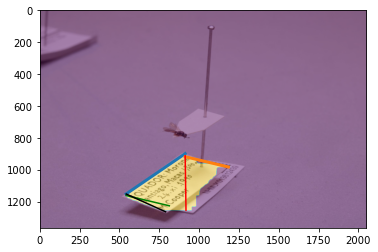

In [91]:
fig,ax = plt.subplots()
ax.imshow(img_orig)
ax.imshow(mask,alpha=0.4)
for i in range(0,2):
    ax.plot(new_lines[i][0],new_lines[i][1],linewidth=3)
    
ax.plot(line[0],line[1],'-r')

ax.plot(new_lines[1][0]-xe,new_lines[1][1]-ye,'-g')
ax.plot(coords2[7][0],coords2[7][1],'-k')

In [103]:
corners_x2 = [B2[0],coords2[7][0][-1],coords2[7][0][0],x1]
corners_y2 = [B2[1],coords2[7][1][-1],coords2[7][1][0],y1]

In [105]:
short_inds, long_inds, _, dists_dict = define_label_sides(corners_x2, corners_y2)

# 4) Update corners of parallelogram:
corners_x_updated2, corners_y_updated2 = reconfigure_corner(
    short_inds, long_inds, dists_dict, corners_x2, corners_y2
)

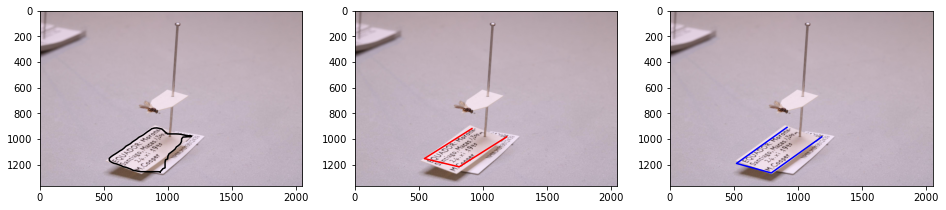

In [110]:
fig,ax = plt.subplots(1,3,figsize=(16,5))
ax[0].imshow(img_orig)
ax[1].imshow(img_orig)
ax[2].imshow(img_orig)

ax[0].plot(contours[0],contours[1],'-k')
ax[1].plot(corners_x_updated, corners_y_updated,'-r')
ax[2].plot(corners_x_updated2, corners_y_updated2,'-b')


#### Data

In [13]:
pth_to_images1 = '../../ALICE_Data/resized/train'
pth_to_images2 = '../../ALICE_Data/resized/val'
pth_to_masks = 'CNN_Results/sample_tests/samp_masks'

In [16]:
df = pd.read_csv('sample_names.csv')

df['Mask_Path'] = [pth_to_masks+'/'+f for f in df['Mask']]

img_paths = []

for img in df['Image']:
    try:
        img_pth = pth_to_images1+'/'+img
        _ = io.imread(img_pth)
    except:
        img_pth = pth_to_images2+'/'+img
    img_paths.append(img_pth)
    
df['Image_Path'] = img_paths

In [17]:
specimen_sample = np.unique(df['Position_ID'])

### Alternative Corner Method

__IDEA 2__: Tests using cv2.approxPolyDP on the original mask contour to find the four corners

In [430]:
contours = find_label_contour_boundaries(msk)
contours = contours[0]
# Reparametrize contour:
contour_x, contour_y = reparam(contours[0][:, 1], contours[0][:, 0], 80)

In [431]:
tst = np.zeros((len(contour_x),1,2),dtype='int32')
tst[:,0,0] = np.int_(contour_y)
tst[:,0,1] = np.int_(contour_x)

In [432]:
peri = cv2.arcLength(tst, True)
approx = cv2.approxPolyDP(tst, 0.02 * peri, True)

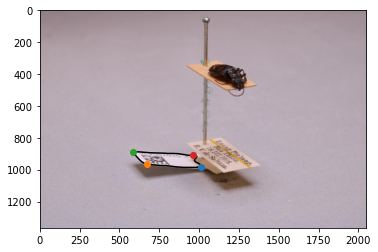

In [377]:
fig,ax =plt.subplots()
ax.imshow(img)
ax.plot(contour_x,contour_y,'-k')
for a in approx:
    ax.plot(a[0][1],a[0][0],'o')

In [433]:
a = np.argmin(approx[:,0,1])
b = np.argmax(approx[:,0,1])
c = np.argmin(approx[:,0,0])
d = np.argmax(approx[:,0,0])

In [434]:
new_approx = approx[np.sort([a,b,c,d]),:,:]

In [435]:
corners_x1, corners_y1,contours = find_corners_v2(msk)

In [436]:
corners_x2 = list(new_approx[:,0,1])
corners_y2 = list(new_approx[:,0,0])

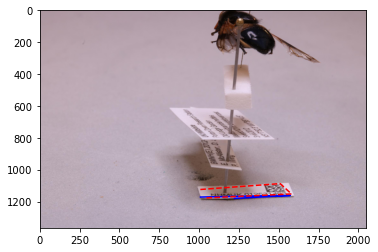

In [438]:
fig,ax = plt.subplots()
ax.imshow(img)
ax.plot(corners_x1,corners_y1,'-b',corners_x2,corners_y2,'--r')

In [380]:
def backup_corner_method(contour_x,contour_y):

    tst = np.zeros((len(contour_x),1,2),dtype='int32')
    tst[:,0,0] = np.int_(contour_y)
    tst[:,0,1] = np.int_(contour_x)

    peri = cv2.arcLength(tst, True)
    approx = cv2.approxPolyDP(tst, 0.02 * peri, True)
    
    new_approx = deepcopy(approx)
    if len(approx) != 4:
        a = np.argmin(approx[:,0,1])
        b = np.argmax(approx[:,0,1])
        c = np.argmin(approx[:,0,0])
        d = np.argmax(approx[:,0,0])
        new_approx = approx[np.sort([a,b,c,d]),:,:]
            

    corners_x2_ = list(new_approx[:,0,1])
    corners_y2_ = list(new_approx[:,0,0])

    return corners_x2_,corners_y2_

### Detecting Bad Label Corners

__Idea 3__: Can we check if label corners are bad, and hence use an alternative method? --> Angles and intersections.

#### 1. Angle Comparisons

In [444]:
k = 44

msk_pth = df['Mask_Path'].iloc[k]
img_pth = df['Image_Path'].iloc[k]

In [445]:
mask, img_orig, corners_x, corners_y = find_corners(
        msk_pth,
        img_pth,
        ydist=True,
        combine_extra_masks=True,
        paths=True,
    )


corners_x2, corners_y2,contours = find_corners_v2(mask)

# Define short sides and long sides:
short_inds, long_inds, _, dists_dict = define_label_sides(corners_x2, corners_y2)

# Update corners of parallelogram:
corners_x_updated2, corners_y_updated2 = reconfigure_corner(
    short_inds, long_inds, dists_dict, corners_x2, corners_y2, method=reconfig_method
)

In [446]:
new_lines, line, swapped, contours = find_direction(mask)

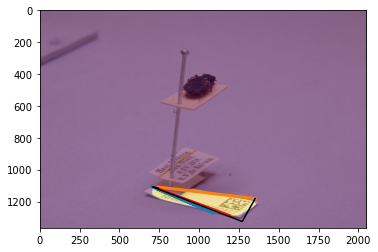

In [448]:
fig,ax = plt.subplots()
ax.imshow(img_orig)
ax.imshow(mask,alpha=0.4)
for i in range(0,2):
    ax.plot(new_lines[i][0],new_lines[i][1],linewidth=3)
    
ax.plot(line[0],line[1],'-r')

ax.plot(corners_x2,corners_y2,'-k')

In [454]:
a1 = get_angle(np.array(corners_x2)[short_inds[0]],np.array(corners_y2)[short_inds[0]], 
      np.array(corners_x2)[long_inds[0]],np.array(corners_y2)[long_inds[0]])

a2 = get_angle(np.array(corners_x2)[short_inds[1]],np.array(corners_y2)[short_inds[1]], 
      np.array(corners_x2)[long_inds[0]],np.array(corners_y2)[long_inds[0]])

a3 = get_angle(np.array(corners_x2)[short_inds[1]],np.array(corners_y2)[short_inds[1]], 
      np.array(corners_x2)[long_inds[1]],np.array(corners_y2)[long_inds[1]])

a4 = get_angle(np.array(corners_x2)[short_inds[0]],np.array(corners_y2)[short_inds[0]], 
      np.array(corners_x2)[long_inds[1]],np.array(corners_y2)[long_inds[1]])

In [455]:
any(angle<10 for angle in [a1,a2,a3,a4])

True

In [263]:
def check_angles(corners_x2,corners_y2,short_inds,long_inds,min_angle=5):
    
    a1 = get_angle(np.array(corners_x2)[short_inds[0]],np.array(corners_y2)[short_inds[0]], 
          np.array(corners_x2)[long_inds[0]],np.array(corners_y2)[long_inds[0]])
    
    a2 = get_angle(np.array(corners_x2)[short_inds[1]],np.array(corners_y2)[short_inds[1]], 
          np.array(corners_x2)[long_inds[0]],np.array(corners_y2)[long_inds[0]])
    
    a3 = get_angle(np.array(corners_x2)[short_inds[1]],np.array(corners_y2)[short_inds[1]], 
          np.array(corners_x2)[long_inds[1]],np.array(corners_y2)[long_inds[1]])
    
    a4 = get_angle(np.array(corners_x2)[short_inds[0]],np.array(corners_y2)[short_inds[0]], 
          np.array(corners_x2)[long_inds[1]],np.array(corners_y2)[long_inds[1]])
    
    A = any(angle<min_angle for angle in [a1,a2,a3,a4])
    
    return A

#### 2. Side Intersections

In [456]:
k = 63

msk_pth = df['Mask_Path'].iloc[k]
img_pth = df['Image_Path'].iloc[k]

In [466]:
mask, img_orig, corners_x, corners_y = find_corners(
        msk_pth,
        img_pth,
        ydist=True,
        combine_extra_masks=True,
        paths=True,
    )


corners_x2, corners_y2,contours = find_corners_v2(mask)

# Define short sides and long sides:
short_inds, long_inds, _, dists_dict = define_label_sides(corners_x2, corners_y2)

# Update corners of parallelogram:
corners_x_updated2, corners_y_updated2 = reconfigure_corner(
    short_inds, long_inds, dists_dict, corners_x2, corners_y2, method=reconfig_method
)

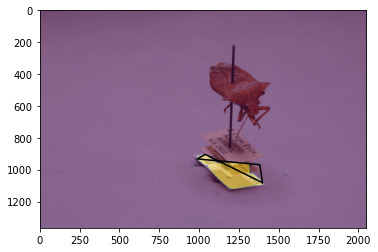

In [464]:
fig,ax = plt.subplots()
ax.imshow(img_orig)
ax.imshow(mask,alpha=0.4)
ax.plot(corners_x2+[corners_x2[0]],corners_y2+[corners_y2[0]],'-k')

In [315]:
def ccw(A,B,C):
    return (C['y']-A['y']) * (B['x']-A['x']) > (B['y']-A['y']) * (C['x']-A['x'])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

In [331]:
def intersection_check(corners_x2,corners_y2,long_inds):

    A1 = {'x':corners_x2[long_inds[0][0]],'y':corners_y2[long_inds[0][0]]}
    B1 = {'x':corners_x2[long_inds[0][1]],'y':corners_y2[long_inds[0][1]]}
    C1 = {'x':corners_x2[long_inds[1][0]],'y':corners_y2[long_inds[1][0]]}
    D1 = {'x':corners_x2[long_inds[1][1]],'y':corners_y2[long_inds[1][1]]}

    return intersect(A1,B1,C1,D1)

In [465]:
A1 = {'x':corners_x2[long_inds[0][0]],'y':corners_y2[long_inds[0][0]]}
B1 = {'x':corners_x2[long_inds[0][1]],'y':corners_y2[long_inds[0][1]]}
C1 = {'x':corners_x2[long_inds[1][0]],'y':corners_y2[long_inds[1][0]]}
D1 = {'x':corners_x2[long_inds[1][1]],'y':corners_y2[long_inds[1][1]]}

intersect(A1,B1,C1,D1)

True

### Tests on Larger Sample

In [388]:
def label_method_comparisons(image_path,mask_path,reconfig_method=0,ydist=True,min_angle=5):

    # METHOD 1
    ##########

    mask, img_orig, corners_x, corners_y = find_corners(
        mask_path,
        image_path,
        ydist=ydist,
        combine_extra_masks=True,
        paths=True,
    )

    # Define short sides and long sides:
    short_inds, long_inds, _, dists_dict = define_label_sides(corners_x, corners_y)
    
    # Update corners of parallelogram:
    corners_x_updated, corners_y_updated = reconfigure_corner(
        short_inds, long_inds, dists_dict, corners_x, corners_y, method=reconfig_method
    )
    
    # METHOD 2
    ##########
    
    corners_x2, corners_y2,contours = find_corners_v2(mask)

    # Define short sides and long sides:
    short_inds, long_inds, _, dists_dict = define_label_sides(corners_x2, corners_y2)
    
    # Emergency Test
    ################
    
    small_angle = check_angles(corners_x,corners_y,short_inds,long_inds,min_angle=min_angle)
    intersect = intersection_check(corners_x,corners_y,long_inds)
    mod1 = 0
    if (small_angle == True) or (intersect == True):
        mod1 = 1
        contour_x, contour_y = reparam(contours[0], contours[1], 80)
        corners_x, corners_y = backup_corner_method(contour_x,contour_y)
        short_inds, long_inds, _, dists_dict = define_label_sides(corners_x, corners_y)

        corners_x_updated, corners_y_updated = reconfigure_corner(
        short_inds, long_inds, dists_dict, corners_x, corners_y, method=reconfig_method)
    
    ##########
    
    small_angle = check_angles(corners_x2,corners_y2,short_inds,long_inds,min_angle=min_angle)
    intersect = intersection_check(corners_x2,corners_y2,long_inds)
    
    mod2 = 0
    if (small_angle == True) or (intersect == True):
        mod2 = 1
        contour_x, contour_y = reparam(contours[0], contours[1], 80)
        corners_x2, corners_y2 = backup_corner_method(contour_x,contour_y)
        short_inds, long_inds, _, dists_dict = define_label_sides(corners_x2, corners_y2)

        
    # Update corners of parallelogram:
    corners_x_updated2, corners_y_updated2 = reconfigure_corner(
        short_inds, long_inds, dists_dict, corners_x2, corners_y2, method=reconfig_method
    )
    
    #####################
    
    corners_x_updated.append(corners_x_updated[0])
    corners_y_updated.append(corners_y_updated[0])
    
    corners_x_updated2.append(corners_x_updated2[0])
    corners_y_updated2.append(corners_y_updated2[0])
    
    corners_1 = [corners_x_updated, corners_y_updated]
    corners_2 = [corners_x_updated2, corners_y_updated2]
    
    return corners_1, corners_2, img_orig,mask,contours,mod1,mod2

(-0.5, 2047.5, 1364.5, -0.5)

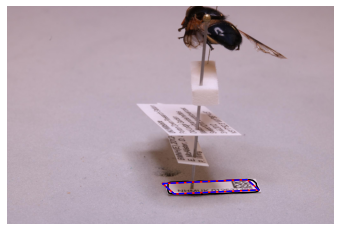

In [439]:
k = 9
c_1, c_2, img,msk,contours,mod1,mod2 = label_method_comparisons(df['Image_Path'].iloc[k],df['Mask_Path'].iloc[k],min_angle=10)

fig,ax = plt.subplots()
ax.imshow(img)
ax.plot(contours[0],contours[1],'-k',c_1[0],c_1[1],'-r',c_2[0],c_2[1],'--b')
ax.axis('off')

In [389]:
fig,ax = plt.subplots(19,4,figsize=(4*4,19*3))

k = 0

n = len(df)

for i in range(0,n):
    if (i%4 == 0) and (i!=0):
        k = k+1
    c_1, c_2, img,msk,contours,mod1,mod2 = label_method_comparisons(df['Image_Path'].iloc[i],df['Mask_Path'].iloc[i],reconfig_method=1,min_angle=10)
    ax[k,i%4].imshow(img)
    ax[k,i%4].plot(contours[0],contours[1],'-k',c_1[0],c_1[1],'-r',c_2[0],c_2[1],'--b')
    ax[k,i%4].axis('off')
    if (mod1 == 1) or (mod2 == 1):
        title = str(i)+" - MODIFIED"
    else:
        title = str(i)
    ax[k,i%4].set_title(title)
    
plt.savefig('tst_corner_methods4_recon1_2.pdf',bbox_inches='tight',dpi=600,pad_inches=0.05)

plt.close('all')